In [1]:
import sys
import os
import numpy as np
import pandas as pd
import sklearn.metrics
from matplotlib import pyplot as plt
from LRGradientDescentWithFeatureTransform import LRGDWithFeatureTransform
from sklearn.linear_model import LogisticRegression

In [2]:
x_NF = np.loadtxt('data_sneaker_vs_sandal/x_train.csv',
        skiprows=1, delimiter=',')
y_N = np.loadtxt('data_sneaker_vs_sandal/y_train.csv',
        skiprows=1, delimiter=',')

In [4]:
N = y_N.shape[0]
M = int(N/2)
x_tr_MF = x_NF[:M]
y_tr_M = y_N[:M]
x_va_MF = x_NF[M:]
y_va_M = y_N[M:]
print(y_va_M.shape)

(6000,)


### Feature selection
The features that I implemented do not reflect the ones I eventually used. I divided these features into two sections. 

What worked: 
The feature that had a positive influence on the error rate was one that rounds up all nonblack colors to 1. As a result, all black areas in the picture stay black, but all colors become white. As a result, the holes in the shoe make it much more obvious to spot for the regression. This transformation is seen below: 

What didn't work:
I tried to use three additional features: One that counted the number of clusters, one that counted the number of light pixels, and one that transformed the pixels into label.measure.
    To count the number of light pixels, I simply called np.count_nonzero and appended that number to the end of each feature array. My thinking behind this was that there may be more white pixels in pictures of sneakers because there are less holes in there than there would be in a sandal. 
    For the feature that counted the number of clusters, and one that transformed it into label.measure, I used scipy.ndimage's label.measurements, which returns an array that IDs each cluster of nonzero numbers and a number of clusters. An input picture and its corresponding array is shown below: 
    
    
My thought process behind this was that by showing the different clusters with different numbers, the regression could more easily classify because of the different nonzero numbers. I think that it made it worse because it would train it based on the larger weights from the cluster numbers, which do not correlate at all with differentiating between sandal and sneaker. 
I also appended the total number of clusters at the end of each feature array, which is the 2nd return value of label.measurements. My thought process behind this was that maybe the larger number of clusters, the more likely it is a sandal because of the different gaps/holes in the shoes. These three features, combined with the one that worked yielded this result on the leaderboard:




### Alpha Selection

When choosing an alpha for my logistic regression, I decided to use an equation that Professor Hughes used in class in that 1/2C = alpha. With C = 0.1, alpha = 5, which means that overfitting is punished through means of the L2 penalty. 

### Train for Submission

In [63]:
lr = LRGDWithFeatureTransform(C=0.1, solver='lbfgs', max_iter=10000)
lr.fit(x_NF, y_N)
#lr.fit(x_tr_MF, y_tr_M)



LRGDWithFeatureTransform(C=0.1, class_weight=None, dual=False,
             fit_intercept=True, intercept_scaling=1, max_iter=10000,
             multi_class='warn', n_jobs=None, penalty='l2',
             random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
             warm_start=False)

In [19]:
x_test_NF = np.loadtxt('data_sneaker_vs_sandal/x_test.csv', skiprows=1, delimiter=',')

yproba1_test_N = lr.predict_proba(x_test_NF)[:, 1]

np.savetxt('data_sneaker_vs_sandal/yproba1_test.txt', yproba1_test_N)

In [33]:
lrnf = LogisticRegression(C=0.1, solver='lbfgs', max_iter=10000)
lrnf.fit(x_tr_MF, y_tr_M)
lrf = LRGDWithFeatureTransform(C=0.1, solver='lbfgs', max_iter=10000)
lrf.fit(x_tr_MF, y_tr_M)


LRGDWithFeatureTransform(C=0.1, class_weight=None, dual=False,
             fit_intercept=True, intercept_scaling=1, max_iter=10000,
             multi_class='warn', n_jobs=None, penalty='l2',
             random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
             warm_start=False)

### ROC Curve

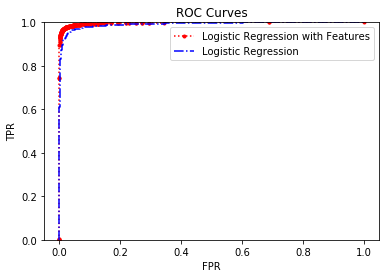

In [34]:
proba_lr_f = lrf.predict_proba(x_va_MF)[:, 1]
proba_lr = lrnf.predict_proba(x_va_MF)[:, 1]
plt.ylim([0, 1]);
plt.xlabel("FPR");
plt.ylabel("TPR");
fprlr, tprlr, thrlr = sklearn.metrics.roc_curve(y_va_M, proba_lr_f)
fprlrnf, tprlrnf, thrlrnf = sklearn.metrics.roc_curve(y_va_M, proba_lr)
plt.plot(fprlr, tprlr, 'r.:', label = "Logistic Regression with Features")
plt.plot(fprlrnf, tprlrnf, 'b-.', label = "Logistic Regression")
plt.title("ROC Curves")
plt.legend()

In [35]:
def calc_confusion_matrix_for_threshold(ytrue_N, yproba1_N, thresh):
    cm = sklearn.metrics.confusion_matrix(ytrue_N, yproba1_N >= thresh)
    cm_df = pd.DataFrame(data=cm, columns=[0, 1], index=[0, 1])
    cm_df.columns.name = 'Predicted'
    cm_df.index.name = 'True'
    return cm_df

### Confusion Matrices

In [36]:
print("Confusion Matrix for Logistic Regression without Features")
calc_confusion_matrix_for_threshold(y_va_M, proba_lr, 0.5)

Confusion Matrix for Logistic Regression without Features


Predicted,0,1
True,,
0,2900,97
1,142,2861


In [37]:
print("Confusion Matrix for Logistic Regression with Features")
calc_confusion_matrix_for_threshold(y_va_M, proba_lr_f, 0.5)

Confusion Matrix for Logistic Regression with Features


Predicted,0,1
True,,
0,2954,43
1,92,2911


In [38]:
###show mistakes with recreations of false and true positives, use argwhere and corrections, also show transformation

(21, 1)
(16, 1)


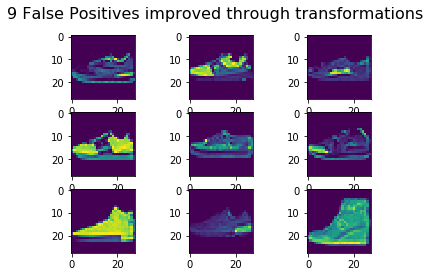

In [59]:
FP_N_f = np.logical_and(y_va_M < 0.5, proba_lr_f >= 0.5)
FN_N_f = np.logical_and(y_va_M > 0.5, proba_lr_f < 0.5)
FP_N_nf = np.logical_and(y_va_M < 0.5, proba_lr >= 0.5)
FN_N_nf = np.logical_and(y_va_M > 0.5, proba_lr < 0.5)



FP_improved = np.logical_and(FP_N_nf==True, FP_N_nf!=FP_N_f)
FN_improved = np.logical_and(FN_N_nf==True, FN_N_nf!=FN_N_f)
FP_notimp = np.logical_and(FP_N_nf==True, FP_N_nf==FP_N_f)
FN_notimp = np.logical_and(FN_N_nf==True, FN_N_nf==FN_N_f)
isTrue_worse = np.logical_and(tru_nf==True, proba_lr_f < 0.5)
isFalse_worse = np.logical_and(false_nf==True, proba_lr_f >= 0.5)

FP_locf_N = np.argwhere(FP_N_f == True)
FN_locf_N = np.argwhere(FN_N_f == True)
FP_locnf_N = np.argwhere(FP_N_nf == True)
FN_locnf_N = np.argwhere(FN_N_nf == True)

FP_imp_pics = np.argwhere(FP_improved == True)
FN_imp_pics = np.argwhere(FN_improved == True)
FP_nimp_pics = np.argwhere(FP_notimp == True)
FN_nimp_pics = np.argwhere(FN_notimp == True)

f, axlist = plt.subplots(3, 3, sharex=False)
f.suptitle('9 False Positives improved through transformations', fontsize=16)
for i in range(3):
    for j in range(3):
        axlist[i][j].imshow(x_va_MF[FP_imp_pics[i*3+j]].reshape(28,28), vmin=0.0, vmax=1.0)

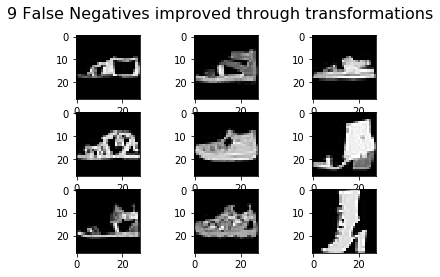

In [54]:
f, axlist = plt.subplots(3, 3, sharex=False)
f.suptitle('9 False Negatives improved through transformations', fontsize=16)
for i in range(3):
    for j in range(3):
        axlist[i][j].imshow(x_va_MF[FN_imp_pics[i*3+j]].reshape(28,28), cmap="gray", vmin=0.0, vmax=1.0)

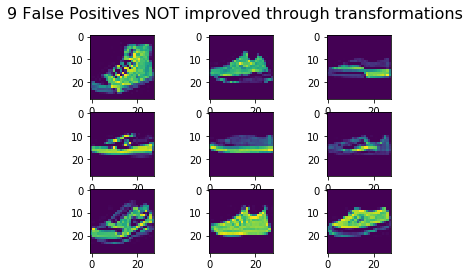

In [55]:
f, axlist = plt.subplots(3, 3, sharex=False)
f.suptitle('9 False Positives NOT improved through transformations', fontsize=16)
for i in range(3):
    for j in range(3):
        axlist[i][j].imshow(x_va_MF[FP_nimp_pics[i*3+j]].reshape(28,28), vmin=0.0, vmax=1.0)

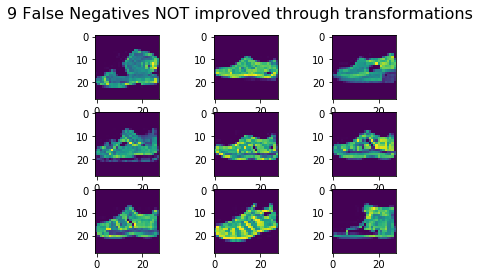

In [57]:
f, axlist = plt.subplots(3, 3, sharex=False)
f.suptitle('9 False Negatives NOT improved through transformations', fontsize=16)
for i in range(3):
    for j in range(3):
        axlist[i][j].imshow(x_va_MF[FN_nimp_pics[i*3+j]].reshape(28,28), vmin=0.0, vmax=1.0)

In [60]:
tru_nf = np.logical_and(y_va_M > 0.5, proba_lr >= 0.5)
false_nf = np.logical_and(y_va_M < 0.5, proba_lr < 0.5)
isTrue_worse = np.logical_and(tru_nf==True, proba_lr_f < 0.5)
isFalse_worse = np.logical_and(false_nf==True, proba_lr_f >= 0.5)
worseTrue = np.argwhere(isTrue_worse == True)
worseFalse =np.argwhere(isFalse_worse == True)
print(worseTrue.shape)
print(worseFalse.shape)

(21, 1)
(16, 1)


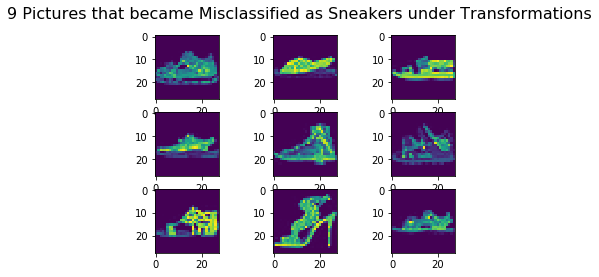

In [61]:
f, axlist = plt.subplots(3, 3, sharex=False)
f.suptitle('9 Pictures that became Misclassified as Sneakers under Transformations', fontsize=16)
for i in range(3):
    for j in range(3):
        axlist[i][j].imshow(x_va_MF[worseTrue[i*3+j]].reshape(28,28), vmin=0.0, vmax=1.0)

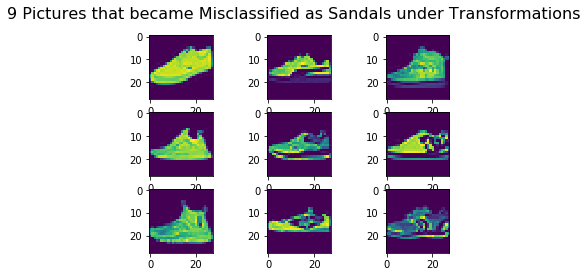

In [62]:
f, axlist = plt.subplots(3, 3, sharex=False)
f.suptitle('9 Pictures that became Misclassified as Sandals under Transformations', fontsize=16)
for i in range(3):
    for j in range(3):
        axlist[i][j].imshow(x_va_MF[worseFalse[i*3+j]].reshape(28,28), vmin=0.0, vmax=1.0)

AttributeError: 'LRGDWithFeatureTransform' object has no attribute 'w_G'